# X-ray image processing

This tutorial demonstrates how to read and process X-ray images with NumPy,
imageio, Matplotlib and SciPy. You will learn how to load medical images, focus
on certain parts, and visually compare them using the
[Gaussian](https://en.wikipedia.org/wiki/Gaussian_filter),
[Laplacian-Gaussian](https://en.wikipedia.org/wiki/Laplace_distribution),
[Sobel](https://en.wikipedia.org/wiki/Sobel_operator), and
[Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) filters for edge
detection.

X-ray image analysis can be part of your data analysis and
[machine learning workflow](https://www.sciencedirect.com/science/article/pii/S235291481930214X)
when, for example, you're building an algorithm that helps
[detect pneumonia](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)
as part of a [Kaggle](https://www.kaggle.com)
[competition](https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen).
In the healthcare industry, medical image processing and analysis is
particularly important when images are estimated to account for
[at least 90%](https://www-03.ibm.com/press/us/en/pressrelease/51146.wss) of all
medical data.

You'll be working with radiology images from the
[ChestX-ray8](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)
dataset provided by the [National Institutes of Health (NIH)](http://nih.gov).
ChestX-ray8 contains over 100,000 de-identified X-ray images in the PNG format
from more than 30,000 patients. You can find ChestX-ray8's files on NIH's public
Box [repository](https://nihcc.app.box.com/v/ChestXray-NIHCC) in the `/images`
folder. (For more details, refer to the research
[paper](http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf)
published at CVPR (a computer vision conference) in 2017.)

For your convenience, a small number of PNG images have been saved to this
tutorial's repository under `tutorial-x-ray-image-processing/`, since
ChestX-ray8 contains gigabytes of data and you may find it challenging to
download it in batches.

![A series of 9 x-ray images of the same region of a patient's chest is shown with different types of image processing filters applied to each image. Each x-ray shows different types of biological detail.](_static/tutorial-x-ray-image-processing.png)

## Prerequisites

The reader should have some knowledge of Python, NumPy arrays, and Matplotlib.
To refresh the memory, you can take the
[Python](https://docs.python.org/dev/tutorial/index.html) and Matplotlib
[PyPlot](https://matplotlib.org/tutorials/introductory/pyplot.html) tutorials,
and the NumPy [quickstart](https://numpy.org/devdocs/user/quickstart.html).

The following packages are used in this tutorial:

- [imageio](https://imageio.github.io) for reading and writing image data. The
healthcare industry usually works with the
[DICOM](https://en.wikipedia.org/wiki/DICOM) format for medical imaging and
[imageio](https://imageio.readthedocs.io/en/stable/format_dicom.html) should be
well-suited for reading that format. For simplicity, in this tutorial you'll be
working with PNG files.
- [Matplotlib](https://matplotlib.org/) for data visualization.
- [SciPy](https://www.scipy.org) for multi-dimensional image processing via
[`ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html).

This tutorial can be run locally in an isolated environment, such as
[Virtualenv](https://virtualenv.pypa.io/en/stable/) or
[conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).
You can use [Jupyter Notebook or JupyterLab](https://jupyter.org/install) to run
each notebook cell.

## Table of contents

1. Examine an X-ray with `imageio`
2. Combine images into a multi-dimensional array to demonstrate progression
3. Edge detection using the Laplacian-Gaussian, Gaussian gradient, Sobel, and
   Canny filters
4. Apply masks to X-rays with `np.where()`
5. Compare the results

---

## Examine an X-ray with `imageio`

Let's begin with a simple example using just one X-ray image from the
ChestX-ray8 dataset.

The file — `00000011_001.png` — has been downloaded for you and saved in the
`/tutorial-x-ray-image-processing` folder.

**1.** Load the image with `imageio`:

In [1]:
import os
import imageio

DIR = "tutorial-x-ray-image-processing"

xray_image = imageio.imread(os.path.join(DIR, "00000011_001.png"))

**2.** Check that its shape is 1024x1024 pixels and that the array is made up of
8-bit integers:

In [2]:
print(xray_image.shape)
print(xray_image.dtype)

(1024, 1024)
uint8


**3.** Import `matplotlib` and display the image in a grayscale colormap:

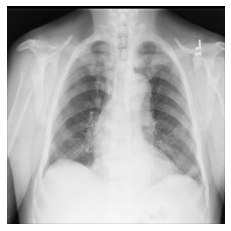

In [3]:
import matplotlib.pyplot as plt

plt.imshow(xray_image, cmap="gray")
plt.axis("off")
plt.show()

## Combine images into a multidimensional array to demonstrate progression

In the next example, instead of 1 image you'll use 9 X-ray 1024x1024-pixel
images from the ChestX-ray8 dataset that have been downloaded and extracted
from one of the dataset files. They are numbered from `...000.png` to
`...008.png` and let's assume they belong to the same patient.

**1.** Import NumPy, read in each of the X-rays, and create a three-dimensional
array where the first dimension corresponds to image number:

In [4]:
import numpy as np
num_imgs = 9

combined_xray_images_1 = np.array(
    [imageio.imread(os.path.join(DIR, f"00000011_00{i}.png")) for i in range(num_imgs)]
)

**2.** Check the shape of the new X-ray image array containing 9 stacked images:

In [5]:
combined_xray_images_1.shape

(9, 1024, 1024)

Note that the shape in the first dimension matches `num_imgs`, so the
`combined_xray_images_1` array can be interpreted as a stack of 2D images.

**3.** You can now display the "health progress" by plotting each of frames next
to each other using Matplotlib:

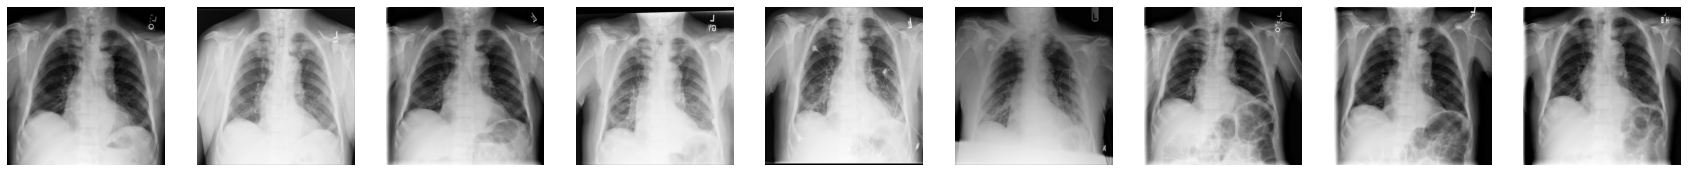

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=num_imgs, figsize=(30, 30))

for img, ax in zip(combined_xray_images_1, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

**4.** In addition, it can be helpful to show the progress as an animation.
Let's create a GIF file with `imageio.mimwrite()` and display the result in the
notebook:

In [7]:
GIF_PATH = os.path.join(DIR, "xray_image.gif")
imageio.mimwrite(GIF_PATH, combined_xray_images_1, format= ".gif", fps=1)

Which gives us:
![An animated gif repeatedly cycles through a series of 8 x-rays, showing the same viewpoint of the patient's chest at different points in time. The patient's bones and internal organs can be visually compared from frame to frame.](tutorial-x-ray-image-processing/xray_image.gif)
## Edge detection using the Laplacian-Gaussian, Gaussian gradient, Sobel, and Canny filters

When processing biomedical data, it can be useful to emphasize the 2D
["edges"](https://en.wikipedia.org/wiki/Edge_detection) to focus on particular
features in an image. To do that, using
[image gradients](https://en.wikipedia.org/wiki/Image_gradient) can be
particularly helpful when detecting the change of color pixel intensity.

### The Laplace filter with Gaussian second derivatives

Let's start with an n-dimensional
[Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) filter
("Laplacian-Gaussian") that uses
[Gaussian](https://en.wikipedia.org/wiki/Normal_distribution) second
derivatives. This Laplacian method focuses on pixels with rapid intensity change
in values and is combined with Gaussian smoothing to
[remove noise](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm). Let's examine
how it can be useful in analyzing 2D X-ray images.

- The implementation of the Laplacian-Gaussian filter is relatively
straightforward: 1) import the `ndimage` module from SciPy; and 2) call
[`scipy.ndimage.gaussian_laplace()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_laplace.html)
with a sigma (scalar) parameter, which affects the standard deviations of the
Gaussian filter (you'll use `1` in the example below):

In [8]:
from scipy import ndimage

xray_image_laplace_gaussian = ndimage.gaussian_laplace(xray_image, sigma=1)

Display the original X-ray and the one with the Laplacian-Gaussian filter:

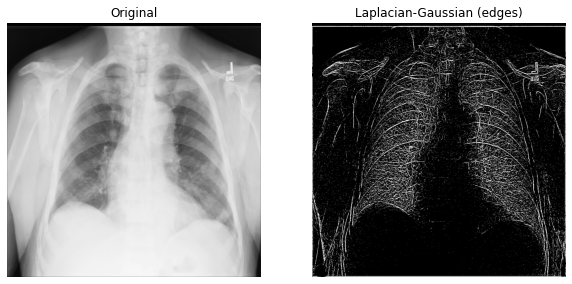

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Laplacian-Gaussian (edges)")
axes[1].imshow(xray_image_laplace_gaussian, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

### The Gaussian gradient magnitude method

Another method for edge detection that can be useful is the
[Gaussian](https://en.wikipedia.org/wiki/Normal_distribution) (gradient) filter.
It computes the multidimensional gradient magnitude with Gaussian derivatives
and helps by remove
[high-frequency](https://www.cs.cornell.edu/courses/cs6670/2011sp/lectures/lec02_filter.pdf)
image components.

**1.** Call [`scipy.ndimage.gaussian_gradient_magnitude()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_gradient_magnitude.html)
with a sigma (scalar) parameter (for standard deviations; you'll use `2` in the
example below):

In [10]:
x_ray_image_gaussian_gradient = ndimage.gaussian_gradient_magnitude(xray_image, sigma=2)

**2.** Display the original X-ray and the one with the Gaussian gradient filter:

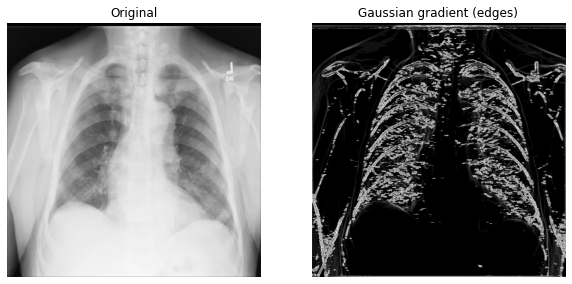

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Gaussian gradient (edges)")
axes[1].imshow(x_ray_image_gaussian_gradient, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

### The Sobel-Feldman operator (the Sobel filter)

To find regions of high spatial frequency (the edges or the edge maps) along the
horizontal and vertical axes of a 2D X-ray image, you can use the
[Sobel-Feldman operator (Sobel filter)](https://en.wikipedia.org/wiki/Sobel_operator)
technique. The Sobel filter applies two 3x3 kernel matrices — one for each axis
— onto the X-ray through a [convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution).
Then, these two points (gradients) are combined using the
[Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) to
produce a gradient magnitude.

**1.** Use the Sobel filters — ([`scipy.ndimage.sobel()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html))
— on x- and y-axes of the X-ray. Then, calculate the distance between `x` and
`y` (with the Sobel filters applied to them) using the
[Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) and
NumPy's [`np.hypot()`](https://numpy.org/doc/stable/reference/generated/numpy.hypot.html)
to obtain the magnitude. Finally, normalize the rescaled image for the pixel
values to be between 0 and 255.

[Image normalization](https://en.wikipedia.org/wiki/Normalization_%28image_processing%29)
follows the `output_channel = 255.0 * (input_channel - min_value) / (max_value - min_value)`
[formula](http://dev.ipol.im/~nmonzon/Normalization.pdf). Because you're
using a grayscale image, you need to normalize just one channel.

In [12]:
x_sobel = ndimage.sobel(xray_image, axis=0)
y_sobel = ndimage.sobel(xray_image, axis=1)

xray_image_sobel = np.hypot(x_sobel, y_sobel)

xray_image_sobel *= 255.0 / np.max(xray_image_sobel)

**2.** Change the new image array data type to the 32-bit floating-point format
from `float16` to [make it compatible](https://github.com/matplotlib/matplotlib/issues/15432)
with Matplotlib:

In [13]:
print("The data type - before: ", xray_image_sobel.dtype)

xray_image_sobel = xray_image_sobel.astype("float32")

print("The data type - after: ", xray_image_sobel.dtype)

The data type - before:  float16
The data type - after:  float32


**3.** Display the original X-ray and the one with the Sobel "edge" filter
applied. Note that both the grayscale and `CMRmap` colormaps are used to help
emphasize the edges:

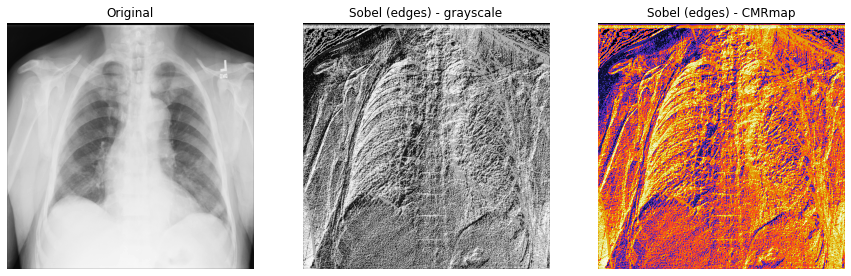

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Sobel (edges) - grayscale")
axes[1].imshow(xray_image_sobel, cmap="gray")
axes[2].set_title("Sobel (edges) - CMRmap")
axes[2].imshow(xray_image_sobel, cmap="CMRmap")
for i in axes:
    i.axis("off")
plt.show()

### The Canny filter

You can also consider using another well-known filter for edge detection called
the [Canny filter](https://en.wikipedia.org/wiki/Canny_edge_detector).

First, you apply a [Gaussian](https://en.wikipedia.org/wiki/Gaussian_filter)
filter to remove the noise in an image. In this example, you're using using the
[Fourier](https://en.wikipedia.org/wiki/Fourier_transform) filter which
smoothens the X-ray through a [convolution](https://en.wikipedia.org/wiki/Convolution)
process. Next, you apply the [Prewitt filter](https://en.wikipedia.org/wiki/Prewitt_operator)
on each of the 2 axes of the image to help detect some of the edges — this will
result in 2 gradient values. Similar to the Sobel filter, the Prewitt operator
also applies two 3x3 kernel matrices — one for each axis — onto the X-ray
through a [convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution).
In the end, you compute the magnitude between the two gradients using the
[Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) and
[normalize](https://en.wikipedia.org/wiki/Normalization_%28image_processing%29)
the images, as before.

**1.** Use SciPy's Fourier filters — [`scipy.ndimage.fourier_gaussian()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.fourier_gaussian.html)
— with a small `sigma` value to remove some of the noise from the X-ray. Then,
calculate two gradients using [`scipy.ndimage.prewitt()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.prewitt.html).
Next, measure the distance between the gradients using NumPy's `np.hypot()`.
Finally, [normalize](https://en.wikipedia.org/wiki/Normalization_%28image_processing%29)
the rescaled image, as before.

In [15]:
fourier_gaussian = ndimage.fourier_gaussian(xray_image, sigma=0.05)

x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)

xray_image_canny = np.hypot(x_prewitt, y_prewitt)

xray_image_canny *= 255.0 / np.max(xray_image_canny)

print("The data type - ", xray_image_canny.dtype)

The data type -  float64


**2.** Plot the original X-ray image and the ones with the edges detected with
the help of the Canny filter technique. The edges can be emphasized using the
`prism`, `nipy_spectral`, and `terrain` Matplotlib colormaps.

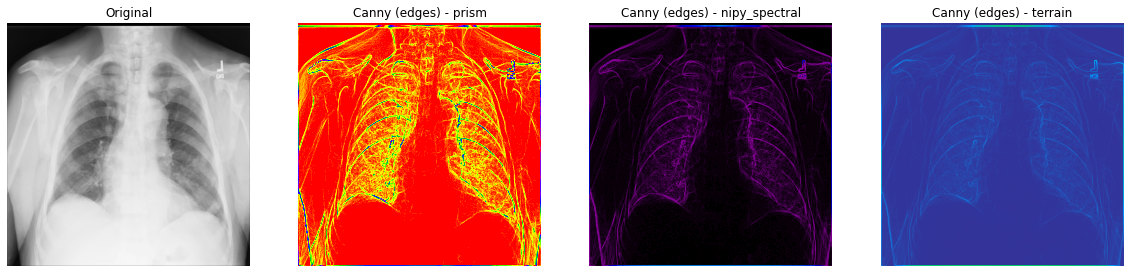

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Canny (edges) - prism")
axes[1].imshow(xray_image_canny, cmap="prism")
axes[2].set_title("Canny (edges) - nipy_spectral")
axes[2].imshow(xray_image_canny, cmap="nipy_spectral")
axes[3].set_title("Canny (edges) - terrain")
axes[3].imshow(xray_image_canny, cmap="terrain")
for i in axes:
    i.axis("off")
plt.show()

## Apply masks to X-rays with `np.where()`

To screen out only certain pixels in X-ray images to help detect particular
features, you can apply masks with NumPy's
[`np.where(condition: array_like (bool), x: array_like, y: ndarray)`](https://numpy.org/doc/stable/reference/generated/numpy.where.html)
that returns `x` when `True` and `y` when `False`.

Identifying regions of interest — certain sets of pixels in an image — can be
useful and masks serve as boolean arrays of the same shape as the original
image.

**1.** Retrieve some basics statistics about the pixel values in the original
X-ray image you've been working with:

In [17]:
print("The data type of the X-ray image is: ", xray_image.dtype)
print("The minimum pixel value is: ", np.min(xray_image))
print("The maximum pixel value is: ", np.max(xray_image))
print("The average pixel value is: ", np.mean(xray_image))
print("The median pixel value is: ", np.median(xray_image))

The data type of the X-ray image is:  uint8
The minimum pixel value is:  0
The maximum pixel value is:  255
The average pixel value is:  172.52233219146729
The median pixel value is:  195.0


**2.** The array data type is `uint8` and the minimum/maximum value results
suggest that all 256 colors (from `0` to `255`) are used in the X-ray. Let's
visualize the _pixel intensity distribution_ of the original raw X-ray image
with `ndimage.histogram()` and Matplotlib:

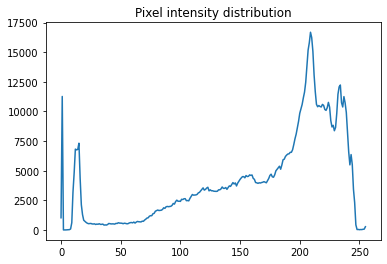

In [18]:
pixel_intensity_distribution = ndimage.histogram(
    xray_image, min=np.min(xray_image), max=np.max(xray_image), bins=256
)

plt.plot(pixel_intensity_distribution)
plt.title("Pixel intensity distribution")
plt.show()

As the pixel intensity distribution suggests, there are many low (between around
0 and 20) and very high (between around 200 and 240) pixel values.

**3.** You can create different conditional masks with NumPy's `np.where()` —
for example, let's have only those values of the image with the pixels exceeding
a certain threshold:

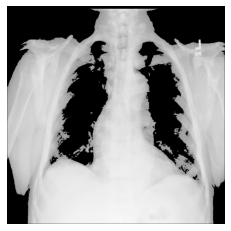

In [19]:
# The threshold is "greater than 150"
# Return the original image if true, `0` otherwise
xray_image_mask_noisy = np.where(xray_image > 150, xray_image, 0)

plt.imshow(xray_image_mask_noisy, cmap="gray")
plt.axis("off")
plt.show()

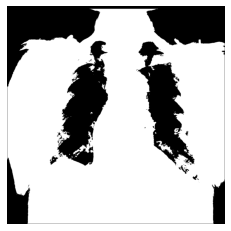

In [20]:
# The threshold is "greater than 150"
# Return `1` if true, `0` otherwise
xray_image_mask_less_noisy = np.where(xray_image > 150, 1, 0)

plt.imshow(xray_image_mask_less_noisy, cmap="gray")
plt.axis("off")
plt.show()

## Compare the results

Let's display some of the results of processed X-ray images you've worked with
so far:

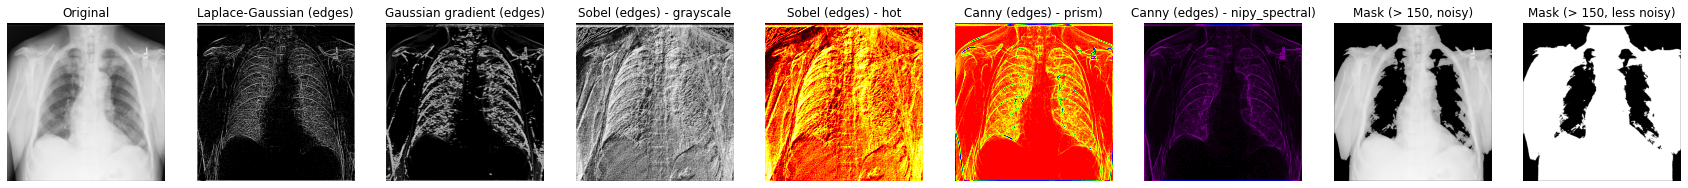

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(30, 30))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Laplace-Gaussian (edges)")
axes[1].imshow(xray_image_laplace_gaussian, cmap="gray")
axes[2].set_title("Gaussian gradient (edges)")
axes[2].imshow(x_ray_image_gaussian_gradient, cmap="gray")
axes[3].set_title("Sobel (edges) - grayscale")
axes[3].imshow(xray_image_sobel, cmap="gray")
axes[4].set_title("Sobel (edges) - hot")
axes[4].imshow(xray_image_sobel, cmap="hot")
axes[5].set_title("Canny (edges) - prism)")
axes[5].imshow(xray_image_canny, cmap="prism")
axes[6].set_title("Canny (edges) - nipy_spectral)")
axes[6].imshow(xray_image_canny, cmap="nipy_spectral")
axes[7].set_title("Mask (> 150, noisy)")
axes[7].imshow(xray_image_mask_noisy, cmap="gray")
axes[8].set_title("Mask (> 150, less noisy)")
axes[8].imshow(xray_image_mask_less_noisy, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

## Next steps

If you want to use your own samples, you can use
[this image](https://openi.nlm.nih.gov/detailedresult?img=CXR3666_IM-1824-1001&query=chest%20infection&it=xg&req=4&npos=32)
or search for various other ones on the [_Openi_](https://openi.nlm.nih.gov)
database. Openi contains many biomedical images and it can be especially helpful
if you have low bandwidth and/or are restricted by the amount of data you can
download.

To learn more about image processing in the context of biomedical image data or
simply edge detection, you may find the following material useful:

- [DICOM processing and segmentation in Python](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/) with Scikit-Image and pydicom (Radiology Data Quest)
- [Image manipulation and processing using Numpy and Scipy](https://scipy-lectures.org/advanced/image_processing/index.html) (Scipy Lecture Notes)
- [Intensity values](https://s3.amazonaws.com/assets.datacamp.com/production/course_7032/slides/chapter2.pdf) (presentation, DataCamp)
- [Object detection with Raspberry Pi and Python](https://makersportal.com/blog/2019/4/23/image-processing-with-raspberry-pi-and-python-part-ii-spatial-statistics-and-correlations) (Maker Portal)
- [X-ray data preparation and segmentation](https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen) with deep learning (a Kaggle-hosted Jupyter notebook)
- [Image filtering](https://www.cs.cornell.edu/courses/cs6670/2011sp/lectures/lec02_filter.pdf) (lecture slides, CS6670: Computer Vision, Cornell University)
- [Edge detection in Python](https://towardsdatascience.com/edge-detection-in-python-a3c263a13e03) and NumPy (Towards Data Science)
- [Edge detection](https://datacarpentry.org/image-processing/08-edge-detection/) with Scikit-Image (Data Carpentry)
- [Image gradients and gradient filtering](https://www.cs.cmu.edu/~16385/s17/Slides/4.0_Image_Gradients_and_Gradient_Filtering.pdf) (lecture slides, 16-385 Computer Vision, Carnegie Mellon University)